QUANTITATIVE TRAIT LOCI are regions of the genome associated with traits such as height, BMI etc.. If the trait is an expression of a gene then we are faced with an eQTL. 

# Imports and Consts

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_PAH = "./Dataset/"
RNAFILENAME = "GD660.GeneQuantRPKM.txt"
VCFFILENAME = "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf"
CHOSEN_CHROMOSOME = 19

# Load and preprocess data

In [3]:
rnaSeqData = pd.read_csv(DATASET_PAH + RNAFILENAME, delimiter="\t")

In [4]:
rnaSeqData

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.94950,0.95837,0.51002,0.29422,0.22960,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53929,ENSG00000172297.6,ENSG00000172297.6,Y,27600708,0.13907,0.10224,0.00000,0.08924,0.19945,0.00000,...,0.07151,0.00000,0.18889,0.08700,0.15464,0.13199,0.19273,0.15151,0.11010,0.15483
53930,ENSG00000259738.1,ENSG00000259738.1,15,59157205,0.00000,0.13191,0.00000,0.00000,0.15789,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53931,ENSG00000212040.1,ENSG00000212040.1,14,101498324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53932,ENSG00000125266.5,ENSG00000125266.5,13,107187462,0.12923,0.07601,0.32377,0.25588,0.05295,0.16194,...,0.34558,0.12560,0.22624,0.08303,0.15089,0.09111,0.13432,0.19148,0.05730,0.12557


In [5]:
f = open(DATASET_PAH + VCFFILENAME, "r")
columns = None
for l in f:
    if "#CHROM" in l:
        columns = l.split("\t")
        break

In [6]:
columns[0] = columns[0].replace("#", "")

In [7]:
columns[len(columns) - 1] = columns[len(columns) - 1].replace("\n", "")

In [8]:
vcfSourceFile = pd.read_csv(
    DATASET_PAH + VCFFILENAME,
    sep="\t",
    comment="#",
    names=columns,
    header=None,
)

/tmp/ipykernel_59916/242614598.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcfSourceFile = pd.read_csv(


In [9]:
vcfSourceFile["ALT"].unique()

array(['<INS:ME:ALU>', '<CN2>', '<CN0>,<CN2>', '<CN0>', '<INS:ME:LINE1>',
       'A', 'G', 'C', 'T', '<INS:ME:SVA>', '<INV>', '<CN0>,<CN2>,<CN3>',
       '<CN2>,<CN3>', '<CN2>,<CN3>,<CN4>,<CN5>', '<INS:MT>',
       '<CN0>,<CN2>,<CN3>,<CN4>,<CN5>,<CN6>,<CN7>', '<CN2>,<CN3>,<CN4>',
       '<CN0>,<CN2>,<CN3>,<CN4>', '<CN0>,<CN2>,<CN3>,<CN4>,<CN5>,<CN6>',
       '<CN0>,<CN2>,<CN3>,<CN4>,<CN5>',
       '<CN2>,<CN3>,<CN4>,<CN5>,<CN6>,<CN7>,<CN8>',
       '<CN2>,<CN3>,<CN4>,<CN5>,<CN6>,<CN7>',
       '<CN2>,<CN3>,<CN4>,<CN5>,<CN6>,<CN7>,<CN8>,<CN9>',
       '<CN2>,<CN3>,<CN4>,<CN5>,<CN6>'], dtype=object)

In [10]:
def processChr(row):
    if row["Chr"] not in ["X", "Y", "M"]:
        row["Chr"] = str(row["Chr"])
    return row


rnaSeqData = rnaSeqData.apply(lambda x: processChr(x), axis=1)

In [11]:
rnaSeqData["Chr"].unique()

array(['11', '6', '15', '16', 'Y', '4', '1', '7', '10', '22', '20', '14',
       '2', '8', '9', '12', '19', '17', '21', '5', '13', '3', 'X', '18',
       'M'], dtype=object)

In [12]:
def processCHROM(row):
    if row["CHROM"] not in ["X", "Y", "M"]:
        row["CHROM"] = str(row["CHROM"])
    return row


vcfSourceFile = vcfSourceFile.apply(lambda x: processCHROM(x), axis=1)

vcfSourceFile["CHROM"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'],
      dtype=object)

In [13]:
vcfSourceFile.groupby(by="CHROM").size()

CHROM
1     4671
10    3126
11    3375
12    3299
13    2485
14    2097
15    1867
16    2062
17    1926
18    2005
19    1621
2     5642
20    1569
21     877
22     848
3     4811
4     4780
5     4425
6     4187
7     4200
8     3681
9     3001
X     2263
dtype: int64

In [14]:
rnaSeqData.groupby(by="Chr").size()

Chr
1     5172
10    2199
11    3121
12    2747
13    1185
14    2182
15    2021
16    2292
17    2207
18     562
19    1939
2     3872
20    1276
21     694
22    1187
3     2917
4     2494
5     2734
6     2794
7     2770
8     2315
9     2334
M       37
X     2328
Y      555
dtype: int64

In [15]:
vcfSourceFile.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096',
       ...
       'NA21128', 'NA21129', 'NA21130', 'NA21133', 'NA21135', 'NA21137',
       'NA21141', 'NA21142', 'NA21143', 'NA21144'],
      dtype='object', length=2513)

In [16]:
vcfSourceFile["CHROM"] = vcfSourceFile["CHROM"].apply(lambda x: str(x))
# I pick only 1 chromosome to make sure the computation time is reasonable
vcfSourceFile = vcfSourceFile[vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)].copy()

In [17]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
61640,19,251548,DUP_gs_CNV_19_251548_283564,C,<CN2>,.,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61641,19,266428,DUP_uwash_chr19_266428_341459,T,<CN2>,.,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61642,19,286841,DUP_gs_CNV_19_286841_307454,T,"<CN0>,<CN2>",.,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61643,19,293937,BI_GS_DEL1_B2_P2673_28,G,<CN0>,100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61644,19,323368,DUP_gs_CNV_19_323368_334484,A,"<CN0>,<CN2>",.,PASS,"AC=1,8;AF=0.00019968,0.00159744;AFR_AF=0,0.002...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63256,19,58999008,SVA_umary_SVA_769,T,<INS:ME:SVA>,.,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63257,19,59015810,BI_GS_DEL1_B2_P2732_9,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63258,19,59020256,UW_VH_3019,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63259,19,59021221,BI_GS_DEL1_B5_P2732_16,T,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [18]:
newColumns = []
for i in range(len(rnaSeqData.columns)):
    newColumns.append(rnaSeqData.columns[i].split(".")[0])

In [19]:
rnaSeqData.columns = newColumns

In [20]:
rnaSeqData = rnaSeqData[rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)].copy()

In [21]:
rnaSeqData = rnaSeqData.loc[:, ~rnaSeqData.columns.duplicated()].copy()

In [22]:
commonColumns = rnaSeqData.columns.intersection(vcfSourceFile.columns)

In [23]:
commonColumns

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00108',
       ...
       'NA20809', 'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814',
       'NA20815', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=445)

In [24]:
vcfSourceFile["QUAL"] = vcfSourceFile["QUAL"].apply(lambda x: int(x) if x != "." else 0)
vcfSourceFile = vcfSourceFile[vcfSourceFile["QUAL"] > 90]

In [25]:
# vcfSourceFile[(vcfSourceFile['POS']>=vcfSourceFile['POS'].min())&(vcfSourceFile['POS']<vcfSourceFile['POS'].min()+2000000)]

In [26]:
# for column in commonColumns:
#   vcfSourceFile[column] = vcfSourceFile[column].apply(

#       lambda x: [int(n) for n in x.split("|") if int(n)!=0] if x != "." else 0
#  )
# for column in columns:
#   vcfSourceFile = vcfSourceFile.explode(column)

In [27]:
# Data preprocessing: ensuring proper types, mapping
import warnings

warnings.filterwarnings("ignore")

for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(
        # lambda x: sum([int(n) for n in x.split("|")]) if x != "." else 0
        lambda x: sum([int(n) for n in x.split("|")]) if x != "." else 0
    )
for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(lambda x: int(x))

vcfSourceFile["ALT"] = vcfSourceFile["ALT"].apply(lambda x: x.split(","))


# def processRow(row):
#    for column in commonColumns:
#        if row[column] != 0:
#            row[column] = row["ALT"][row[column] - 1]
#    return row


# vcfSourceFile = vcfSourceFile.apply(lambda x: processRow(x), axis=1)

In [28]:
# def countUniqueALTs(row, d):
#    uniqueALTs = row[commonColumns].unique()
#    rowId = row.name
#    d[rowId] = {}
#    for alt in uniqueALTs:
#        if alt == 0:
#            continue
#        d[rowId][alt] = 0
#        for column in commonColumns:
#            if row[column] == alt:
#                d[rowId][alt] = d[rowId][alt] + 1
#    for alt in d[rowId]:
#        row[alt] = d[rowId][alt]
#    return row
#
#
# d = {}
# vcfSourceFileCountedAlts = vcfSourceFile.apply(lambda x: countUniqueALTs(x, d), axis=1)

In [29]:
vcfSourceFile["POS"]

61643      293937
61646      363073
61648      393559
61650      445744
61651      565965
           ...   
63254    58820778
63257    59015810
63258    59020256
63259    59021221
63260    59035015
Name: POS, Length: 968, dtype: int64

In [30]:
rnaSeqData.columns

Index(['TargetID', 'Gene_Symbol', 'Chr', 'Coord', 'HG00096', 'HG00097',
       'HG00099', 'HG00100', 'HG00101', 'HG00102',
       ...
       'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814', 'NA20815',
       'NA20816', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=466)

In [31]:
rnaSeqData["Coord"]

33       58581338
51       32417479
86       50706885
140      55583407
193      45681485
           ...   
53781    19384074
53798    40079595
53806    17666460
53807    58790318
53863    52196593
Name: Coord, Length: 1939, dtype: int64

In [32]:
rnaSeqData = rnaSeqData.reset_index()

In [33]:
vcfSourceFileCountedAlts = vcfSourceFile.reset_index()

In [34]:
def findClosestRna(rnaRow, closestRna, vcfRow):
    distance = np.abs(vcfRow["POS"] - rnaRow["Coord"])
    closestRna.append([distance, rnaRow.name])


def mergeRnaOnClosest(row, rna):
    closestRna = []
    rna.apply(lambda x: findClosestRna(x, closestRna, row), axis=1)
    # Merge on closestRna
    # print(closestRna["closest"])

    closestRnaDf = pd.DataFrame(closestRna, columns=["Distance", "Name"])

    row["RNAIndex"] = (
        closestRnaDf.sort_values(by="Distance", ascending=True)
        .head(3)["Name"]
        .to_list()
    )
    return row


rnaSeqData["mean"] = rnaSeqData[commonColumns].mean(axis=1)
vcfRnaMerged = vcfSourceFileCountedAlts.apply(
    lambda x: mergeRnaOnClosest(x, rnaSeqData), axis=1
).reset_index()

In [35]:
vcfRnaMerged = vcfRnaMerged.explode("RNAIndex")

In [36]:
vcfRnaMerged["RNAIndex"]

0       691
0       520
0      1829
1      1379
1       520
       ... 
966    1900
966    1045
967    1900
967     457
967    1122
Name: RNAIndex, Length: 2904, dtype: object

In [37]:
rnaBaseColumns = ["TargetID", "Gene_Symbol", "Chr", "Coord"]
vcfBaseColumns = [
    "CHROM",
    "POS",
    "ID",
    "REF",
    "ALT",
    "QUAL",
    "FILTER",
    "INFO",
    "FORMAT",
]

In [38]:
vcfSourceFile[vcfBaseColumns + list(commonColumns)][
    vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)
]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
61643,19,293937,BI_GS_DEL1_B2_P2673_28,G,[<CN0>],100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61646,19,363073,SI_BD_16093,G,[<CN0>],100,PASS,AC=3;AF=0.00059904;AFR_AF=0;AMR_AF=0.0029;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61648,19,393559,YL_CN_TSI_3819,G,[<CN0>],100,PASS,AC=3319;AF=0.66274;AFR_AF=0.7746;AMR_AF=0.6138...,GT,1,...,0,1,0,0,1,0,0,0,1,1
61650,19,445744,EM_DL_DEL45228,C,[<CN0>],100,PASS,AC=4;AF=0.00079872;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61651,19,565965,EM_DL_DEL45232,C,[<CN0>],100,PASS,AC=1099;AF=0.219449;AFR_AF=0.2428;AMR_AF=0.111...,GT,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63254,19,58820778,BI_GS_DEL1_B2_P2731_539,A,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63257,19,59015810,BI_GS_DEL1_B2_P2732_9,G,[<CN0>],100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63258,19,59020256,UW_VH_3019,C,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63259,19,59021221,BI_GS_DEL1_B5_P2732_16,T,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
rnaSeqData[rnaBaseColumns + list(commonColumns)][
    rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)
]

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
0,ENSG00000243642.1,ENSG00000243642.1,19,58581338,0.00000,0.00000,0.00000,0.00000,0.00000,0.21415,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,ENSG00000221504.1,ENSG00000221504.1,19,32417479,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000105357.9,ENSG00000105357.9,19,50706885,0.00000,0.00893,0.01107,0.00000,0.00000,0.00000,...,0.01808,0.00000,0.00958,0.00773,0.00000,0.00928,0.01433,0.01631,0.00593,0.00000
3,ENSG00000131037.8,ENSG00000131037.8,19,55583407,0.30019,0.36200,0.43385,0.35353,0.24540,0.06797,...,0.27190,0.27774,0.37089,0.25377,0.24257,0.11613,0.05664,0.39721,0.44654,0.20085
4,ENSG00000007255.5,ENSG00000007255.5,19,45681485,20.41195,19.88715,19.50962,13.88066,13.49203,3.20345,...,29.79700,18.38779,14.77266,14.41909,21.12137,6.88149,10.83442,22.96336,19.30111,9.72888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,ENSG00000213996.3,ENSG00000213996.3,19,19384074,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1935,ENSG00000244253.1,ENSG00000244253.1,19,40079595,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1936,ENSG00000130309.4,ENSG00000130309.4,19,17666460,11.26085,10.45836,13.02215,11.28219,13.15124,6.49617,...,18.04743,14.34539,12.72421,14.71541,10.31135,11.17458,15.14622,11.52041,11.30648,9.77187
1937,ENSG00000083842.6,ENSG00000083842.6,19,58790318,2.14528,2.32057,2.45383,1.55192,2.37085,1.49983,...,1.17241,1.12695,2.22265,1.72124,1.40424,1.09540,1.84351,1.87085,1.79343,1.64816


# Perform linear regression

In [40]:
vcfRnaMerged.iloc[0]["ALT"]

['<CN0>']

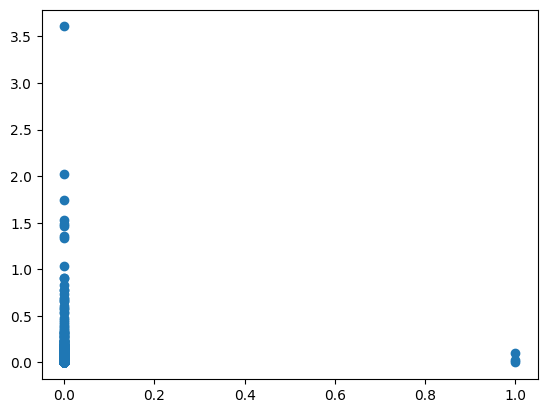

In [41]:
plt.scatter(
    x=vcfRnaMerged.iloc[0][commonColumns].astype(int).to_frame().T.to_numpy()[0],
    y=rnaSeqData.iloc[vcfRnaMerged.iloc[0]["RNAIndex"]][commonColumns],
)
plt.show()

In [42]:
p_values = {}
for index, row in vcfRnaMerged.iterrows():
    mod = statsmodels.api.OLS(
        row[commonColumns].astype(int).to_frame().T.to_numpy()[0],
        rnaSeqData.iloc[row["RNAIndex"]][commonColumns]
        .astype(float)
        .to_frame()
        .T.to_numpy()[0],
    )
    fii = mod.fit()

    p_values[row.name] = fii.summary2().tables[1]["P>|t|"]

In [43]:
p_values = {k: v.to_numpy()[0] for k, v in p_values.items() if v.to_numpy()[0] <= 0.05}

In [44]:
rnaSeqData

,index,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,...,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828,mean
0,33,ENSG00000243642.1,ENSG00000243642.1,19,58581338,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.002425
1,51,ENSG00000221504.1,ENSG00000221504.1,19,32417479,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
2,86,ENSG00000105357.9,ENSG00000105357.9,19,50706885,0.00000,0.00893,0.01107,0.00000,0.00000,...,0.00958,0.00773,0.00000,0.00928,0.01433,0.00000,0.01631,0.00593,0.00000,0.017202
3,140,ENSG00000131037.8,ENSG00000131037.8,19,55583407,0.30019,0.36200,0.43385,0.35353,0.24540,...,0.37089,0.25377,0.24257,0.11613,0.05664,0.33964,0.39721,0.44654,0.20085,0.284250
4,193,ENSG00000007255.5,ENSG00000007255.5,19,45681485,20.41195,19.88715,19.50962,13.88066,13.49203,...,14.77266,14.41909,21.12137,6.88149,10.83442,14.14377,22.96336,19.30111,9.72888,20.672071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,53781,ENSG00000213996.3,ENSG00000213996.3,19,19384074,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000243
1935,53798,ENSG00000244253.1,ENSG00000244253.1,19,40079595,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
1936,53806,ENSG00000130309.4,ENSG00000130309.4,19,17666460,11.26085,10.45836,13.02215,11.28219,13.15124,...,12.72421,14.71541,10.31135,11.17458,15.14622,12.42467,11.52041,11.30648,9.77187,11.743656
1937,53807,ENSG00000083842.6,ENSG00000083842.6,19,58790318,2.14528,2.32057,2.45383,1.55192,2.37085,...,2.22265,1.72124,1.40424,1.09540,1.84351,1.86309,1.87085,1.79343,1.64816,2.092930


In [45]:
d = {}
for key in p_values.keys():
    d[key] = {}
    d[key]["GENEPOS"] = vcfRnaMerged.iloc[key]["POS"]
    d[key]["GENEID"] = vcfRnaMerged.iloc[key]["ID"]
    d[key]["ALT"] = vcfRnaMerged.iloc[key]["ALT"]
    d[key]["RNAID"] = rnaSeqData.iloc[row["RNAIndex"]]["TargetID"]
    d[key]["RNACOORD"] = rnaSeqData.iloc[row["RNAIndex"]]["Coord"]
    d[key]["SIG"] = p_values[key]

In [46]:
df = pd.DataFrame(d)

In [47]:
pd.set_option("display.float_format", "{:.2g}".format)
df.T

,GENEPOS,GENEID,ALT,RNAID,RNACOORD,SIG
2,293937,BI_GS_DEL1_B2_P2673_28,[<CN0>],ENSG00000130726.6,59055836,1.1e-99
4,363073,SI_BD_16093,[<CN0>],ENSG00000130726.6,59055836,4e-22
5,363073,SI_BD_16093,[<CN0>],ENSG00000130726.6,59055836,4e-22
6,393559,YL_CN_TSI_3819,[<CN0>],ENSG00000130726.6,59055836,0.036
41,996141,YL_CN_STU_3871,[<CN0>],ENSG00000130726.6,59055836,0.0021
...,...,...,...,...,...,...
896,16109630,BI_GS_DEL1_B3_P2689_4,[<CN0>],ENSG00000130726.6,59055836,9.4e-06
904,16414305,SI_BD_16358,[<CN0>],ENSG00000130726.6,59055836,0.0056
925,17059392,BI_GS_DEL1_B5_P2690_57,[<CN0>],ENSG00000130726.6,59055836,1.2e-16
926,17059392,BI_GS_DEL1_B5_P2690_57,[<CN0>],ENSG00000130726.6,59055836,2.7e-06


In [49]:
df.T.to_csv("regressionResults.csv")